## Sentiment Analysis in Python

# Introduction

In this notebook, we will perform sentiment analysis in Python using three different techniques:
1. VADER (Valence Aware Dictionary and sEntiment Reasoner) - Bag of words approach
2. Roberta Pretrained Model from 🤗 Huggingface Pipeline
3. Transformer pipeline



In [67]:
import plotly.express as px
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
import nltk
import ftfy
import string
import re
from transformers import pipeline
import pandas as pd

#Run the below "download" lines of code only once while starting the program
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('maxent_ne_chunker')
#nltk.download('vader_lexicon')
#nltk.download('words')

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'
px.defaults.height = 500
px.defaults.width = 800

In [68]:
#Read csv file
df = pd.read_csv('user_review.csv')

In [69]:
df.head()

,id,review
0,1,I love this app! It is so useful and easy to use.
1,2,Terrible experience. The app crashes all the t...
2,3,Decent app but needs improvement in the UI.
3,4,Fantastic! This app has changed my life.
4,5,"The app is okay, but it lacks many features."


## Data Preprocessing
 Clean encoding issues using ftfy library

In [70]:
#read one review, seems there are encoding issues in reviews
df['review'].values[46]

'The app doesnâ€™t have enough tutorials.'

In [71]:
df['review'] = df['review'].apply(ftfy.fix_text)

## Text preprocessing function
The preprocess_text function helps in standardizing and simplifying the text data by:
 1 Converting all text to lowercase, ensuring consistency.
 2 Removing punctuation, reducing noise and simplifying the text.

In [72]:
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    def clean_text(text):
        '''
        Utility function to clean tweet text by removing links, special characters
        using simple regex statements.
        '''
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text).split())
    text = clean_text(text)
    return text

df['cleaned_review'] = df['review'].apply(preprocess_text)

## Basic NLTK

In [73]:
example = df['cleaned_review'][45]
print(example)

helpful customer support


In [74]:
#tokenize the review now
tokens= nltk.word_tokenize(example)
tokens

['helpful', 'customer', 'support']

In [75]:
#Understanding the part of speech is it verb, pronoun, noun etc.
tagged = nltk.pos_tag(tokens)
tagged

[('helpful', 'JJ'), ('customer', 'NN'), ('support', 'NN')]

In [76]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S helpful/JJ customer/NN support/NN)


## VADER Sentiment Scoring

In this step, we will utilize NLTK's SentimentIntensityAnalyzer to compute the negative, neutral, and positive scores of the text. This approach follows a "bag of words" methodology:

1. Stop words are removed from the text.
2. Each word is assigned a sentiment score.
3. These individual scores are combined to generate a total score.


In [77]:
#Here we will use NLTk SenrtimentIntensityAnalyzer to get neg/neu/pos scores
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [78]:
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 0.154, 'pos': 0.846, 'compound': 0.6705}

In [79]:
#Run the polarity score on entire dataset
res ={}
for i, row in tqdm(df.iterrows(), total =len(df)):
    review = row['cleaned_review']
    myid = row['id']
    res[myid] = sia.polarity_scores(review)


  0%|          | 0/50 [00:00<?, ?it/s]

In [80]:
vaders = pd.DataFrame(res).T
vaders
vaders = vaders.reset_index().rename(columns={'index': 'id'})
vaders = vaders.merge(df, how = 'left')

In [81]:
#Here we have sentiment score and metadata merged together
#vaders.head()

In [82]:
#vaders


In [83]:
def get_sentiment(compound):
    
    if compound >= 0.4:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

vaders['sentiment'] = vaders['compound'].apply(get_sentiment)

In [84]:
vaders

,id,neg,neu,pos,compound,review,cleaned_review,sentiment
0,1,0.000,0.419,0.581,0.9023,I love this app! It is so useful and easy to use.,i love this app it is so useful and easy to use,positive
1,2,0.307,0.693,0.000,-0.4767,Terrible experience. The app crashes all the t...,terrible experience the app crashes all the time,negative
2,3,0.000,0.636,0.364,0.6124,Decent app but needs improvement in the UI.,decent app but needs improvement in the ui,positive
3,4,0.000,0.625,0.375,0.5574,Fantastic! This app has changed my life.,fantastic this app has changed my life,positive
4,5,0.000,0.847,0.153,0.1154,"The app is okay, but it lacks many features.",the app is okay but it lacks many features,neutral
5,6,0.369,0.631,0.000,-0.6249,Worst app ever. It is full of bugs.,worst app ever it is full of bugs,negative
6,7,0.000,0.519,0.481,0.5719,Excellent functionality and user-friendly design.,excellent functionality and userfriendly design,positive
7,8,0.000,0.548,0.452,0.6980,"Not bad, but there are better alternatives out...",not bad but there are better alternatives out ...,positive
8,9,0.000,0.536,0.464,0.6353,I'm very satisfied with this app. Highly recom...,im very satisfied with this app highly recomme...,positive
9,10,0.000,1.000,0.000,0.0000,The app is slow and unresponsive at times.,the app is slow and unresponsive at times,neutral


In [85]:
fig = px.histogram(vaders,
                   x = 'sentiment',
                   marginal = 'box',
                   title = 'Sentiments(VADER)')
fig.update_layout(bargap=0.1)
fig.show()


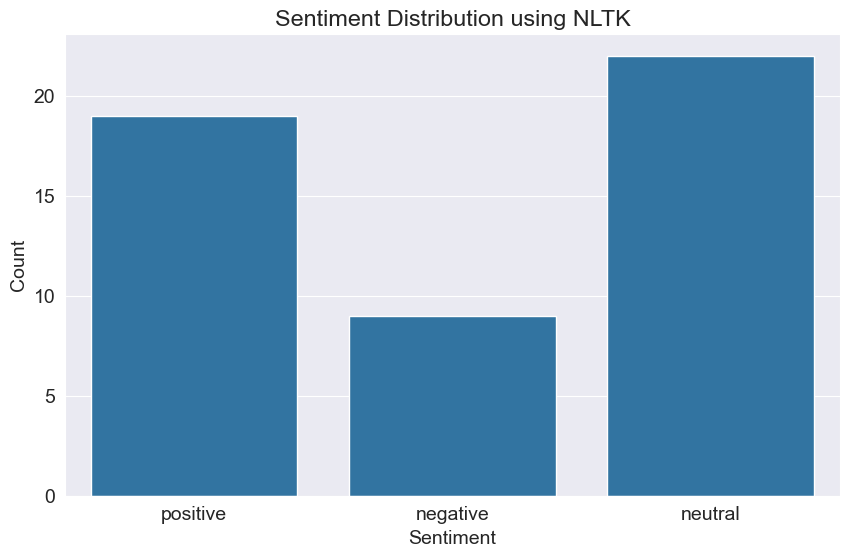

In [86]:
sns.countplot(x='sentiment', data=vaders)
plt.title('Sentiment Distribution using NLTK')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


## Roberta Pretrained Model

We will leverage a pretrained model trained on a vast corpus of data.
 The Transformer model not only considers individual words but also the context in which they appear relative to other words.


In [87]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [88]:
MODEL = f'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

C:\Users\Mohommad Ali\AppData\Roaming\Python\Python310\site-packages\huggingface_hub\file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



In [89]:
#Applying the above model on an example set
print(example)
sia.polarity_scores(example)

helpful customer support


{'neg': 0.0, 'neu': 0.154, 'pos': 0.846, 'compound': 0.6705}

In [90]:
#Run it for Roberta
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example,return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return(scores_dict)
    

In [91]:
res ={}
for i, row in tqdm(df.iterrows(), total = len(df)):
    try:
        review = row['cleaned_review']
        myid = row['id']
        vader_result = sia.polarity_scores(review)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f'vader_{key}'] = value
        roberta_result = polarity_scores_roberta(review)
        both = {**vader_result_rename,**roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id{myid}')
    

  0%|          | 0/50 [00:00<?, ?it/s]

In [92]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'id'})
results_df = results_df.merge(df, how = 'left')

In [93]:
def get_sentiment(compound):
    
    if compound >= 0.4:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

results_df['vader_sentiment'] = results_df['vader_compound'].apply(get_sentiment)
results_df

,id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,review,cleaned_review,vader_sentiment
0,1,0.000,0.419,0.581,0.9023,0.002317,0.005621,0.992062,I love this app! It is so useful and easy to use.,i love this app it is so useful and easy to use,positive
1,2,0.307,0.693,0.000,-0.4767,0.978697,0.018580,0.002723,Terrible experience. The app crashes all the t...,terrible experience the app crashes all the time,negative
2,3,0.000,0.636,0.364,0.6124,0.078857,0.380859,0.540284,Decent app but needs improvement in the UI.,decent app but needs improvement in the ui,positive
3,4,0.000,0.625,0.375,0.5574,0.004705,0.028747,0.966547,Fantastic! This app has changed my life.,fantastic this app has changed my life,positive
4,5,0.000,0.847,0.153,0.1154,0.705159,0.254419,0.040422,"The app is okay, but it lacks many features.",the app is okay but it lacks many features,neutral
5,6,0.369,0.631,0.000,-0.6249,0.982465,0.015060,0.002475,Worst app ever. It is full of bugs.,worst app ever it is full of bugs,negative
6,7,0.000,0.519,0.481,0.5719,0.003319,0.046895,0.949785,Excellent functionality and user-friendly design.,excellent functionality and userfriendly design,positive
7,8,0.000,0.548,0.452,0.6980,0.176046,0.504767,0.319187,"Not bad, but there are better alternatives out...",not bad but there are better alternatives out ...,positive
8,9,0.000,0.536,0.464,0.6353,0.001571,0.009612,0.988817,I'm very satisfied with this app. Highly recom...,im very satisfied with this app highly recomme...,positive
9,10,0.000,1.000,0.000,0.0000,0.962912,0.034196,0.002893,The app is slow and unresponsive at times.,the app is slow and unresponsive at times,neutral


In [94]:
sentiment_res = []

for i, row in tqdm(results_df.iterrows(), total = len(results_df)):
    nue = row['roberta_neu']
    pos = row['roberta_pos']
    neg = row['roberta_neg']
    na_diff_neg = nue-neg
    na_diff_pos = nue-pos
    diff_neg = abs(nue-neg)
    diff_pos = abs(nue-pos)
    #print(f'diff_neg:{diff_neg} diff_pos:{diff_pos}')
    if (diff_neg <= 0.3 and (diff_pos <= 0.5 and diff_pos > 0.1 )) or (diff_pos <= 0.3 and (diff_neg <= 0.5 and diff_neg > 0.1)):
        sentiment_res.append('neutral')
    elif diff_neg < 0.1 and diff_pos < 0.1:
        sentiment_res.append('neutral')
    elif na_diff_neg >0.5 or na_diff_pos > 0.5:
        sentiment_res.append('neutral')
    elif pos > neg:
        sentiment_res.append('positive')
    elif neg > pos:
        sentiment_res.append('negative')
    else:
        sentiment_res.append('NA')


        



  0%|          | 0/50 [00:00<?, ?it/s]

In [95]:
sentiment_df = pd.DataFrame({'roberta_sentiment': sentiment_res})

# Create a new DataFrame with the list as a row
#new_row_df = pd.DataFrame([my_list], columns=df.columns)

# Concatenate the original DataFrame with the new row DataFrame along the row axis (axis=0)
results_df = pd.concat([results_df, sentiment_df], axis=1, ignore_index=False)

## Bar Plot 
Plot for both the Models and then analysing which gives better results

In [96]:
fig = px.histogram(results_df,
                   x = 'roberta_sentiment',
                   marginal = 'box',
                   title = 'Sentiments(ROBERTA)')
fig.update_layout(bargap=0.1)
fig.show()

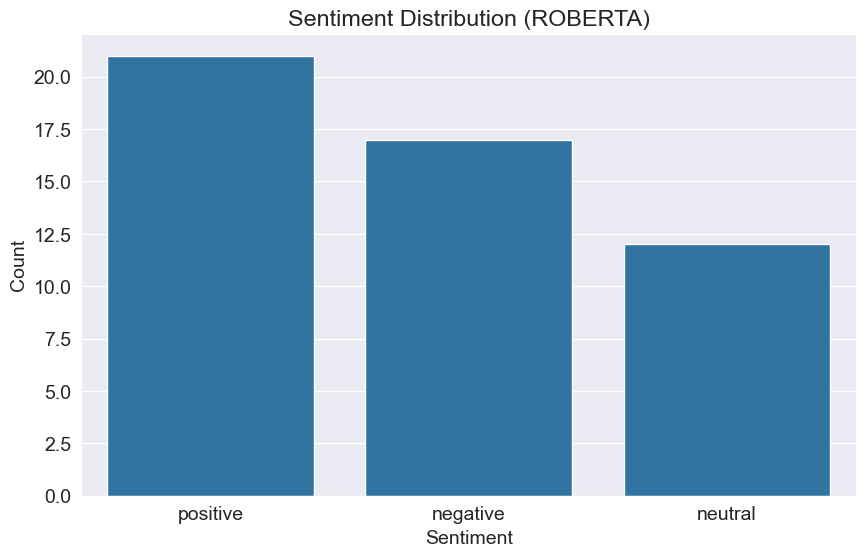

In [97]:
sns.countplot(x='roberta_sentiment', data=results_df)
plt.title('Sentiment Distribution (ROBERTA)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


In [98]:
fig = px.histogram(results_df,
                   x = 'vader_sentiment',
                   marginal = 'box',
                   title = 'Sentiments(VADER)')
fig.update_layout(bargap=0.1)
fig.show()

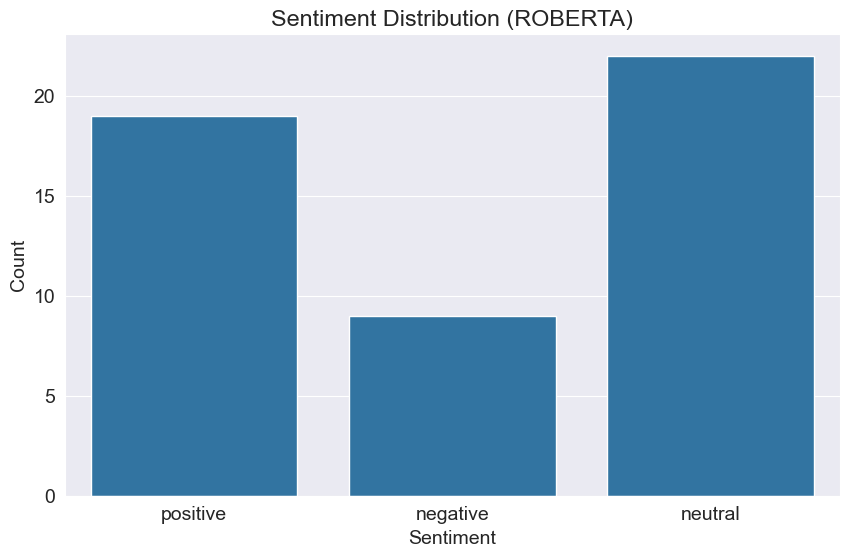

In [99]:
sns.countplot(x='vader_sentiment', data=results_df)
plt.title('Sentiment Distribution (ROBERTA)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

## Hugging Face Transformer Pipeline
Hugging Face's transformers library provides pre-trained models that can be fine-tuned for sentiment analysis.
Here's how you can use a pre-trained BERT model from the Hugging Face library to perform sentiment analysis:

In [100]:
# Use Hugging Face's transformers pipeline for sentiment analysis
sentiment_pipeline = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
C:\Users\Mohommad Ali\AppData\Roaming\Python\Python310\site-packages\huggingface_hub\file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



In [101]:
def get_sentiment_bert(text):
    result = sentiment_pipeline(text)
    label = result[0]['label']
    if label == 'POSITIVE':
        return 'positive'
    elif label == 'NEGATIVE':
        return 'negative'
    else:
        return 'neutral'

In [102]:
pipeline_df = df.copy()

In [103]:
# Apply sentiment analysis
pipeline_df['sentiment'] = pipeline_df['cleaned_review'].apply(get_sentiment_bert)

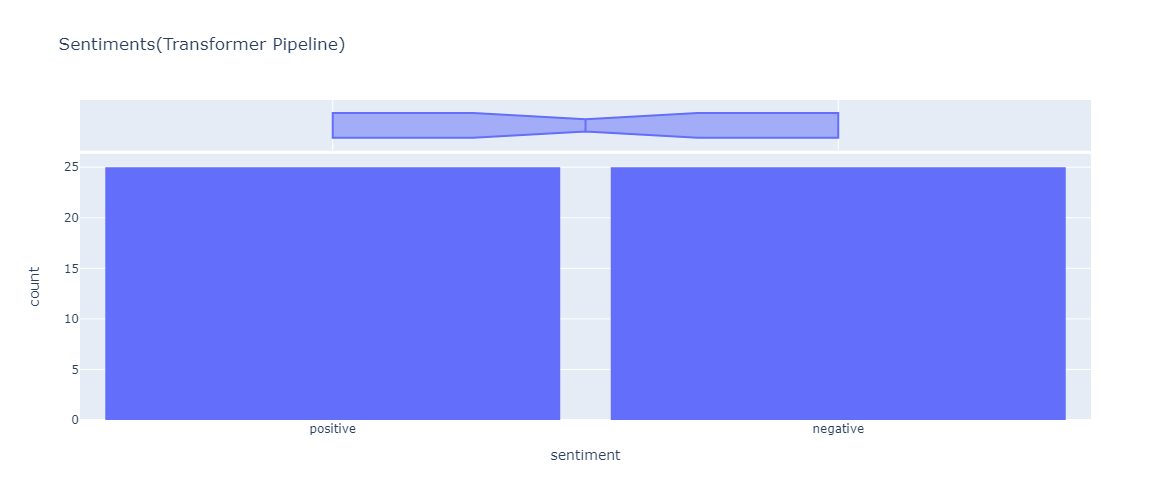

In [104]:
fig = px.histogram(pipeline_df,
                   x = 'sentiment',
                   marginal = 'box',
                   title = 'Sentiments(Transformer Pipeline)')
fig.update_layout(bargap=0.1)
fig.show()

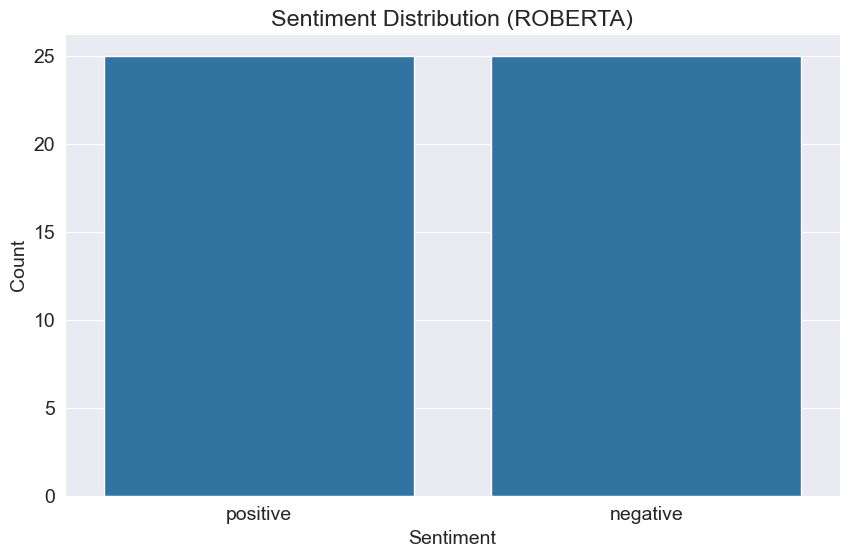

In [105]:
sns.countplot(x='sentiment', data=pipeline_df)
plt.title('Sentiment Distribution (ROBERTA)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()